In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from neurostim.overview_heatmaps import *
from neurostim.opt_res_analysis import prepare_df_for_evaluation, eval_spatial_resolution

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

from scipy.interpolate import RegularGridInterpolator as rgi
def convert_to_3d(opt_res_data, diams, NAs, neuron, ChR_dist, APC, N_interp):
    x = opt_res_data.loc[neuron,ChR_dist,:,:,APC].reset_index().fiber_diameter.values.reshape([len(diams),len(NAs)])
    y = opt_res_data.loc[neuron,ChR_dist,:,:,APC].reset_index().fiber_NA.values.reshape([len(diams),len(NAs)])
    z = opt_res_data.loc[neuron,ChR_dist,:,:,APC].reset_index().x_APC50.values.reshape([len(diams),len(NAs)])
    interp_x = rgi((diams,NAs),x)
    interp_y = rgi((diams,NAs),y)
    interp_z = rgi((diams,NAs),z)
    itp_diams, itp_NAs = np.meshgrid(np.linspace(diams[0],diams[-1],N_interp),np.linspace(NAs[0],NAs[-1],N_interp))
    interp_x = interp_x(np.array([itp_diams.flatten(), itp_NAs.flatten()]).T).reshape(itp_diams.shape)
    interp_y = interp_y(np.array([itp_diams.flatten(), itp_NAs.flatten()]).T).reshape(itp_diams.shape)
    interp_z = interp_z(np.array([itp_diams.flatten(), itp_NAs.flatten()]).T).reshape(itp_diams.shape)
    return interp_x, interp_y, interp_z

def surface_plot_diam_NA_radius(data, neuron, N_interpolation, diams, NAs, APC,clim, figsize):
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=figsize)
    ax.plot_surface(
        *convert_to_3d(data, diams=diams, NAs=NAs, neuron=neuron,ChR_dist='shemesh_supfig9b_exp_lin_yoff', APC=APC, 
                       N_interp=N_interpolation), 
        cmap=matplotlib.cm.Blues, norm=matplotlib.colors.Normalize(clim[0],clim[1]),
        alpha=0.8)
    ax.plot_surface(
        *convert_to_3d(data, diams=diams, NAs=NAs, neuron=neuron,ChR_dist='uniform', APC=APC, 
                       N_interp=N_interpolation), 
        cmap=matplotlib.cm.Reds, norm=matplotlib.colors.Normalize(clim[0],clim[1]),
        alpha=0.8)
        
    ax.set_xticks([25,50,100,200,400])
    ax.set_xticklabels(['','  50','100','200','400'])
    ax.set_yticks([0.1,0.22,0.39,0.5])
    ax.set_zticks([0,100,200])
    ax.set_zticks([50,150,250],minor=True)
    ax.set_xlim(400,25)
    ax.set_ylim(0.1,0.5)
    ax.set_zlim(*clim)
    ax.set_xlabel('diameter [µm]', fontname='Arial')
    ax.set_ylabel('num. aperture')
    ax.set_zlabel('response space\nconstant @50Hz [µm]')
    return fig, ax



# format
legend_fontsize = 9
linestyle='solid'

# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl

# others
dpi=900

# load, prepare and analyze data
#df = pd.read_csv('../../../data/2023-03-03_10spikes_higherChRexpression/complete.csv')
df = pd.read_csv('../../../data/2023-03-03_10spikes_higherChRexpression/all_data.csv')
df = df.astype({
    'hoc_file': 'str',
    'light_model': 'str',
    'chanrhod_distribution': 'str',
    'chanrhod_expression': 'int',
    'fiber_diameter': 'float',
    'fiber_NA': 'float',
    'stim_duration [ms]': 'float',
    'APC_desired': 'float',
    'radius [um]': 'int',
    'angle [rad]': 'float',
    'light_power': 'float',
}).set_index(['hoc_file', 'light_model', 'chanrhod_distribution', 'chanrhod_expression',
              'fiber_diameter', 'fiber_NA', 'stim_duration [ms]', 'APC_desired',
              'radius [um]', 'angle [rad]'])
def convert_str_to_float(x):
    if x=="NaN":
        x=np.nan
    elif x=="failed":
        x=np.nan
    else:
        x = float(x)
    return x
df['AP_count'] = df['AP_count'].apply(convert_str_to_float)
df['firint_rate [Hz]'] = df['firint_rate [Hz]'].apply(convert_str_to_float)
df['time-to-spike [ms]'] = df['time-to-spike [ms]'].apply(convert_str_to_float)
raw_df = df

# define params which are fixed to reduce index accordingly
defaults = dict(
    light_model = 'foutz_et_al2012',
    chanrhod_expression = 13e10,
    stim_duration = 200
)
# extract response radius at specific AP count
df_, df_light_pwr_lookup, failed_search_paramsets = \
    prepare_df_for_evaluation(df=raw_df, defaults_to_reduce=defaults)

df_res, non_monotonic_failed_paramsets = eval_spatial_resolution(
    df_, APC_desired_tolerance=0.1)

In [2]:
print("Parameter sets with nan-value or not simulated ones: ")
for neuron in['L5','L23']:
    for dist in ['uniform','shemesh_supfig9b_exp_lin_yoff']:
        for diam in [25,50,100,200,400]:
            for NA in [0.1,0.22,0.39,0.5]:
                try:
                    if np.isnan(df_res.loc[neuron,dist,diam,NA].x_APC50.values[0]):
                        print('is nan:',neuron, dist, diam, NA,)
                except KeyError:
                    print('does not exist',neuron, dist, diam, NA,)
print("no further parameter sets.")

Parameter sets with nan-value or not simulated ones: 
is nan: L5 uniform 25 0.39
is nan: L5 uniform 50 0.22
is nan: L5 uniform 100 0.1
no further parameter sets.


manually find light source offset at which response drops to half-max for L5 paramsets, for which extraction algorithm failed (due to non monotonicity)


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


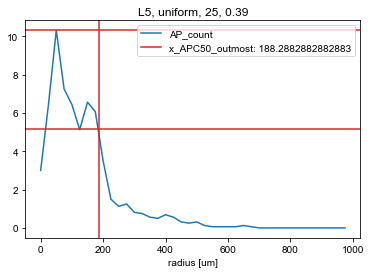

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


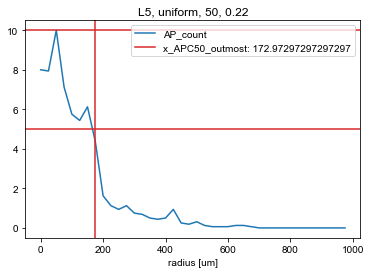

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


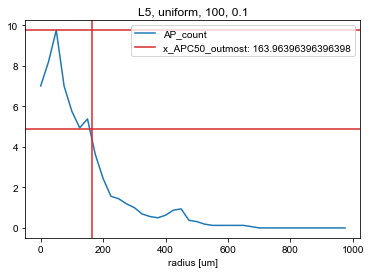

In [3]:
print("manually find light source offset at which response drops to half-max for L5 paramsets, for which extraction algorithm failed (due to non monotonicity)")
for diam, NA in zip([25,50,100],[0.39,0.22,0.1]):
    plot_df = raw_df.loc['L5','foutz_et_al2012','uniform',13e10,diam,NA,200,10]['AP_count'].groupby(['radius [um]']).mean()
    #plt.plot(plot_df.rad
    plot_df.plot()
    plt.axhline(y=plot_df.max(), color='tab:red')
    plt.axhline(y=plot_df.max()/2, color='tab:red')
    # find radius at which AP_count is closest to half-max
    from scipy.interpolate import interp1d
    interpolation = interp1d(plot_df.index, plot_df.values)
    # radius at peak response
    x_APCmax = plot_df[plot_df==plot_df.max()].index.values[0]
    radii_interpolated = np.linspace(0,900,1000)
    APC_interpolated = interpolation(radii_interpolated)
    # find largest radius at which AP count is half-max
    x_APC50_outmost = np.max(radii_interpolated[np.abs(APC_interpolated-plot_df.max()/2)<0.5])
    plt.axvline(x=x_APC50_outmost, color='tab:red',label='x_APC50_outmost: '+str(x_APC50_outmost))
    plt.legend()
    plt.title("L5, uniform, "+str(diam)+', '+str(NA))
    plt.show()
    df_res.loc[('L5','uniform',diam,NA),'x_APC50'] = x_APC50_outmost

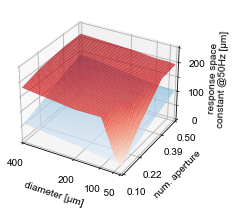

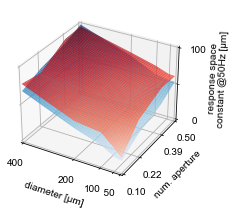

In [4]:
N_interpolation=100
diams=[25,50,100,200,400]
NAs=[0.1,0.22,0.39,0.5]
APC=10
figsize=(pw/2,pw/2)

fig, ax = surface_plot_diam_NA_radius(
    data=df_res, 
    neuron='L5', 
    N_interpolation=N_interpolation, 
    diams=diams, 
    NAs=NAs, 
    APC=APC,
    clim=[0,250], 
    figsize=figsize
)
fig.savefig('plots/L5_13e10_response_radius.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()
fig, ax = surface_plot_diam_NA_radius(
    data=df_res, 
    neuron='L23', 
    N_interpolation=N_interpolation, 
    diams=diams, 
    NAs=NAs, 
    APC=APC,
    clim=[0,100], 
    figsize=figsize
)
fig.savefig('plots/L23_13e10_response_radius.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [5]:
import matplotlib
dir(matplotlib.font_manager)

['FontEntry',
 'FontManager',
 'FontProperties',
 'JSONEncoder',
 'MSFolders',
 'MSFontDirectories',
 'MSUserFontDirectories',
 'Number',
 'OSXFontDirectories',
 'Path',
 'Timer',
 'X11FontDirectories',
 '_JSONEncoder',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_call_fc_list',
 '_fmcache',
 '_get_font',
 '_json_decode',
 '_log',
 '_normalize_font_family',
 '_rebuild',
 '_weight_regexes',
 '_win32RegistryFonts',
 'afm',
 'afmFontProperty',
 'cbook',
 'createFontList',
 'findSystemFonts',
 'findfont',
 'fontManager',
 'font_family_aliases',
 'font_scalings',
 'ft2font',
 'generate_fontconfig_pattern',
 'get_font',
 'get_fontconfig_fonts',
 'get_fontext_synonyms',
 'is_opentype_cff_font',
 'json',
 'json_dump',
 'json_load',
 'list_fonts',
 'logging',
 'lru_cache',
 'mpl',
 'os',
 'parse_fontconfig_pattern',
 'rcParams',
 're',
 'stretch_dict',
 'subprocess',
 'sys',
 'ttfFontProperty',
 'weight_dict',
 'win32FontDi